In [1]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchinfo import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.utils.data import TensorDataset
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from lightning_lite.utilities.seed import seed_everything
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, \
    rec_num_workers
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from sklearn.model_selection import train_test_split

In [2]:
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Global seed set to 0


In [3]:
Default = load_data("Default").dropna()
n = Default.shape[0]
display(Default)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [4]:
cols_to_encode = ["default", "student"]
for col in cols_to_encode:
    Default[col] = (Default[col] == "Yes").astype(int)
cols_to_std = ["student", "balance", "income"]
for col in cols_to_std:
    Default[col] = \
        (Default[col] - np.mean(Default[col])) / np.std(Default[col])
display(Default)

,default,student,balance,income
0,0,-0.645936,-0.218835,0.813187
1,0,1.548141,-0.037616,-1.605496
2,0,-0.645936,0.492410,-0.131212
3,0,-0.645936,-0.632893,0.164031
4,0,-0.645936,-0.102791,0.370915
...,...,...,...,...
9995,0,-0.645936,-0.255990,1.460366
9996,0,-0.645936,-0.160044,-1.039014
9997,0,-0.645936,0.020751,1.883565
9998,0,-0.645936,1.516742,0.236363


In [5]:
X = Default.drop(["default"], axis=1).to_numpy()
Y = Default["default"].to_numpy()
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=1/3, stratify=Y, random_state=1)

In [6]:
class DefaultModel(nn.Module):
    
    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [7]:
default_model = DefaultModel(X.shape[1])
summary(default_model, input_size=X_train.shape,
        col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666]                    --
├─Flatten: 1-1                           [6666, 3]                 [6666, 3]                 --
├─Sequential: 1-2                        [6666, 3]                 [6666, 1]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 1]                 11
│    └─Sigmoid: 2-5                      [6666, 1]                 [6666, 1]                 --
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (M): 0.34
Input size (MB): 0.08
Forward/backward pass

In [8]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
default_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
default_test = TensorDataset(X_test_t, Y_test_t)

In [9]:
max_num_workers = rec_num_workers()

In [10]:
default_dm = SimpleDataModule(default_train, default_test, batch_size=32,
                              num_workers=min(4, max_num_workers), validation=default_test)

In [11]:
default_module = SimpleModule.classification(default_model, num_classes=2, \
    metrics={"accuracy": Accuracy(task="binary")})

In [12]:
default_logger = CSVLogger("logs", name="default")

In [28]:
default_trainer = Trainer(deterministic=True, max_epochs=50, \
                          log_every_n_steps=5, logger=default_logger, callbacks=[ErrorTracker()])
default_trainer.fit(default_module, datamodule=default_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/niccolo/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/default/version_0/checkpoints exists and is not empty.

  | Name  | Type             | Params
-------------------------------------------
0 | model | DefaultModel     | 51    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 209/209 [00:15<00:00, 13.73it/s, v_num=0]       

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 209/209 [00:15<00:00, 13.69it/s, v_num=0]


In [29]:
default_trainer.test(default_module, datamodule=default_dm)

Testing DataLoader 0: 100%|██████████| 105/105 [00:02<00:00, 42.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8680263757705688
        test_loss              825.02734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 825.02734375, 'test_accuracy': 0.8680263757705688}]

In [30]:
default_result = pd.read_csv(default_logger.experiment.metrics_file_path)
display(default_result)

,epoch,step,test_accuracy,test_loss,train_accuracy_epoch,train_accuracy_step,train_loss,valid_accuracy,valid_loss
0,0,0,NaN,NaN,NaN,0.21875,NaN,NaN,NaN
1,0,1,NaN,NaN,NaN,0.34375,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN,0.50000,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,0.56250,NaN,NaN,NaN
4,0,4,NaN,NaN,NaN,0.78125,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3242,49,10444,NaN,NaN,NaN,1.00000,NaN,NaN,NaN
3243,49,10449,NaN,NaN,NaN,1.00000,NaN,NaN,NaN
3244,49,10449,NaN,NaN,NaN,NaN,NaN,0.868026,825.027344
3245,49,10449,NaN,NaN,0.883138,NaN,3.069655,NaN,NaN


In [36]:
train_results = default_result[["epoch", "train_accuracy_epoch"]].dropna()
valid_results = default_result[["epoch", "valid_accuracy"]].dropna()

,epoch,train_accuracy_epoch
210,0,0.731323
421,1,0.833933
632,2,0.854335
843,3,0.833633
1054,4,0.845935
1098,0,0.831083
1142,1,0.835734
1186,2,0.852535
1230,3,0.846385
1274,4,0.857786


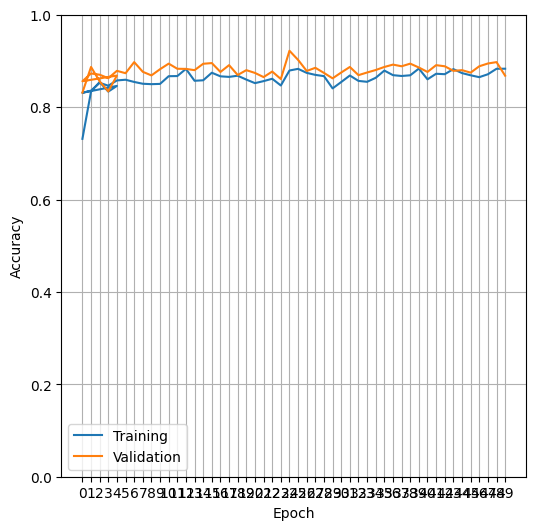

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(train_results["epoch"], train_results["train_accuracy_epoch"], \
    label="Training")
ax.plot(valid_results["epoch"], valid_results["valid_accuracy"], \
    label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 1])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))
ax.legend()
plt.show()